# CAT-DOG IMAGE CLASSIFIER

<p><b>Status: <span style=color:orange;>In progress</span></b></p>

##### LOCATE IMAGE FILE NAMES
Cat : 0 | Dog : 1

In [1]:
import os
import pandas as pd
import numpy as np

data_dir = '../../../data/'
class_list = os.listdir(data_dir)  # get classes based on folder names

filename_list = []

# make a list of the images' file names, cats and dogs
for _class in class_list:
    filename_list_class = os.listdir(data_dir + _class)
    filename_list_class = [(_class + '/' + fname) for fname in filename_list_class if fname.endswith('.jpg')]
    filename_list += filename_list_class

# shuffle the dataset
np.random.seed(45)
np.random.shuffle(filename_list)

# adjust the dataset size
filename_list = filename_list[:300]

print('Total number of files : ', len(filename_list))
filename_list[:10]

Total number of files :  300


['Dog/794.jpg',
 'Cat/11371.jpg',
 'Dog/3937.jpg',
 'Cat/4133.jpg',
 'Dog/4969.jpg',
 'Cat/9435.jpg',
 'Cat/11272.jpg',
 'Dog/2098.jpg',
 'Dog/11725.jpg',
 'Dog/12295.jpg']

## ------- DATA PREPROCESSING -------

##### PREPARE TO STORE DATASET CHARACTERISTICS

In [2]:
# this will store the information from every image
X = []  # feature
y = []  # labels

N_CHANNELS = 3  # three colors: RGB
IMG_SIZE = 227  # image will be converted to 64x64 images

n_images = len(filename_list)

X = np.ndarray(shape=(n_images, IMG_SIZE, IMG_SIZE, N_CHANNELS),
               dtype=np.float32)

##### EXTRACT IMAGE INFORMATION
This block will read every image to resize them and store their labels


0 invalid file(s) were found

Printing the resulting dataset :

LABEL : Dog


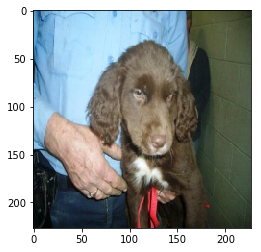


Raw data (first image):


array([[[197., 149.,  91.],
        [193., 146.,  85.],
        [184., 137.,  75.],
        ...,
        [ 32.,  48.,  41.],
        [ 25.,  46.,  38.],
        [ 22.,  45.,  37.]],

       [[199., 152.,  91.],
        [192., 145.,  84.],
        [185., 138.,  76.],
        ...,
        [ 32.,  48.,  41.],
        [ 25.,  46.,  38.],
        [ 24.,  45.,  37.]],

       [[201., 154.,  93.],
        [193., 146.,  85.],
        [187., 139.,  77.],
        ...,
        [ 33.,  49.,  43.],
        [ 29.,  46.,  39.],
        [ 28.,  45.,  38.]],

       ...,

       [[ 25.,  30.,  23.],
        [ 21.,  23.,  17.],
        [ 24.,  21.,  16.],
        ...,
        [ 33.,  41.,  31.],
        [ 31.,  38.,  33.],
        [ 30.,  37.,  32.]],

       [[ 11.,  15.,   9.],
        [ 15.,  17.,  11.],
        [ 25.,  22.,  17.],
        ...,
        [ 32.,  41.,  31.],
        [ 31.,  37.,  32.],
        [ 29.,  36.,  30.]],

       [[ 21.,  25.,  19.],
        [ 19.,  22.,  16.],
        [ 15.,  

In [3]:
%matplotlib inline
from skimage.transform import rescale, resize
import matplotlib.pyplot as plt
import cv2

# deploy a progress bar
try:
    from tqdm.notebook import tqdm
except ImportError:
    def tqdm(x, *args, **kwargs):
        return x


# make a list for the name of failed files
fail_dir_list = []

# count the number of valid images that were read
img_counter = 0

for f in tqdm(range(len(filename_list))):
    try:
        # read every image
        img_path = data_dir + filename_list[f]
        img = cv2.imread(img_path, 1)  # 1 : Color

        # resize every image to the desired size
        img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))

        # build the list with feature data [RGB values]
        X[img_counter, :, :, :] = img

        # split image directory name
        fname_split = filename_list[f].split('/')  # =[Cat, 10.jpg] example
        
        # build the list with labels [cats | dogs]
        class_name = fname_split[0]
        y.append(class_name)

        img_counter += 1

    except Exception as e:
        # log names of files with errors
        fail_dir_list.append(fname)
        pass

# remove empty arrays
X = X[:img_counter]

print('{} invalid file(s) were found\n'.format(len(fail_dir_list)))
print('Printing the resulting dataset :\n')

# plot a sample from the list of images [features]
print('LABEL : ' + y[0])
plt.imshow(cv2.cvtColor(X[0], cv2.COLOR_BGR2RGB).astype(np.uint8))
plt.show()

print('\nRaw data (first image):')
X[0]

##### DATA AUGMENTATION

##### TRANSFORM THE TARGET VALUES TO ONE-HOT ENCODING

In [4]:
y = pd.get_dummies(y)
y.head()

,Cat,Dog
0,0,1
1,1,0
2,0,1
3,1,0
4,0,1


##### SPLIT THE FILE NAMES INTO TRAINING AND TESTING SETS

In [5]:
from sklearn.model_selection import train_test_split

# split the dataset into 2 training and 2 testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=0.2, random_state=13)

# Normalize pixel values to be between 0 and 1
X_train, X_test = X_train / 255.0, X_test / 255.0

print('Data shapes:\n')
print('X_train : {}\ny_train : {}\n\nX_test : {}\ny_test : {}'.format(np.shape(X_train),
                                                                      np.shape(y_train),
                                                                      np.shape(X_test),
                                                                      np.shape(y_test)))

Data shapes:

X_train : (240, 227, 227, 3)
y_train : (240, 2)

X_test : (60, 227, 227, 3)
y_test : (60, 2)


## ------- MODEL TRAINING -------

##### DEFINE NETWORK PARAMETERS

In [6]:
# extract images properties
n_classes = np.shape(y_train)[1]

# count number of samples in each set of data
n_train = np.shape(X_train)[0]
n_test = np.shape(X_test)[0]

# define amount of neurons
n_layer_in = None          # this will depends on the conv layer configurations
n_layer_h1 = 1024          # first   hidden layer
n_layer_h2 = 1024          # second  hidden layer
n_layer_out = n_classes    # 2 neurons in output layer

sigma_init = 0.01   # For randomized initialization

##### RESET TENSORFLOW GRAPH IF THERE IS ANY

In [7]:
import tensorflow as tf

# this will set up a specific seed in order to control the output 
# and get more homogeneous results though every model variation
def reset_graph(seed=127):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
reset_graph()

##### DEFINE MODEL ARCHITECTURE
You can find useful information in the following links:
##### https://ayearofai.com/rohan-lenny-2-convolutional-neural-networks-5f4cd480a60b
##### https://www.guru99.com/convnet-tensorflow-image-classification.html

Convolutional output size:
$$
Conv = \frac{(width-kernel)+(2*Padding)}{stride}+1
$$

Maxpool output size:
$$
MaxPool = \frac{width-pool}{stride}+1
$$

Padding Value when Padding='SAME':
$$
Padding_{SAME} = \frac{width*(stride-1)-stride+kernel}{2}
$$

Number of parameters:
$$
n_{parameters} = ((kernel * channels) + 1) * filters
$$

The general rule is:
By increasing the stride or by using maxpooling, it is possible to reduce the sample, however this will also lose some information. Maxpooling will be more loosely that's why some model nowaday dont use it.


In [8]:
# the basic idea is there is no formula to calculate the optimal stride, kernel, or filter.
# You will have to test them and see how these influence on the results.

# set up some parameters
keep_prob = 0.75

# create symbolic variables
X = tf.placeholder(tf.float32, [None, IMG_SIZE, IMG_SIZE, N_CHANNELS])
Y = tf.placeholder(tf.float32, [None, n_classes])

with tf.name_scope('cnn'):
    
    x_image = tf.reshape(X, [-1, IMG_SIZE, IMG_SIZE, N_CHANNELS])
    
    ###############################################
    ## ------ CONVOLUTIONAL NEURAL NETWORK ------##    
    ###############################################
    
    # Convolutional Layer1
    # input shape : batch_size, 227, 227, 3
    # output shape: batch_size, 55, 55, 96
    conv1 = tf.layers.conv2d(inputs=X,
                             filters=96,
                             kernel_size=[11, 11],
                             strides=(4, 4),
                             padding='valid',
                             activation=tf.nn.relu)

    # Pooling Layer 1
    # input shape : batch_size, 55, 55, 96
    # output shape: batch_size, 27, 27, 96
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[3, 3], strides=2)

    # Convolutional Layer 2
    # input shape : batch_size, 27, 27, 96
    # output shape: batch_size, 27, 27, 256
    conv2 = tf.layers.conv2d(inputs=pool1,
                             filters=256,
                             kernel_size=[5, 5],
                             strides=(1, 1),
                             padding='same',
                             activation=tf.nn.relu)
    
    # Pooling Layer 2
    # input shape : batch_size, 27, 27, 256
    # output shape: batch_size, 13, 13, 256
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[3, 3], strides=2)
    
    
    # Convolutional Layer 3
    # input shape : batch_size, 13, 13, 256
    # output shape: batch_size, 13, 13, 284
    conv3 = tf.layers.conv2d(inputs=pool2,
                             filters=384,
                             kernel_size=[3, 3],
                             strides=(1, 1),
                             padding='same',
                             activation=tf.nn.relu)
    
    
    # Convolutional Layer 4
    # input shape : batch_size, 13, 13, 284
    # output shape: batch_size, 13, 13, 384
    conv4 = tf.layers.conv2d(inputs=conv3,
                             filters=384,
                             kernel_size=[3, 3],
                             strides=(1, 1),
                             padding='same',
                             activation=tf.nn.relu)
    
    
    # Convolutional Layer 5
    # input shape : batch_size, 13, 13, 384
    # output shape: batch_size, 13, 13, 256
    conv5 = tf.layers.conv2d(inputs=conv4,
                             filters=256,
                             kernel_size=[3, 3],
                             strides=(1, 1),
                             padding='same',
                             activation=tf.nn.relu)    
    
    
    # Pooling Layer 5
    # input shape : batch_size, 13, 13, 256
    # output shape: batch_size, 6, 6, 256
    pool5 = tf.layers.max_pooling2d(inputs=conv5, pool_size=[3, 3], strides=2)    
    
    
    
    # input size will be 9216
    flat_shape = int(pool5.get_shape()[1])*int(pool5.get_shape()[2])*int(pool5.get_shape()[3])
    pool5_flat = tf.reshape(pool5, [-1, flat_shape])

    
    ##############################################
    ## ------ FEED FORWARD NEURAL NETWORK ------##
    ##############################################
    
    # deploy the variables that will store the weights
    W = {
        'W1': tf.Variable(tf.random_normal([flat_shape, n_layer_h1], stddev = sigma_init), name='W1'),
        'W2': tf.Variable(tf.random_normal([n_layer_h1, n_layer_h2], stddev = sigma_init), name='W2'),
        'W3': tf.Variable(tf.random_normal([n_layer_h2, n_layer_out], stddev = sigma_init), name='W3'),
    }

    # deploy the variables that will store the bias
    b = {
        'b1': tf.Variable(tf.random_normal([n_layer_h1]), name='b1'),
        'b2': tf.Variable(tf.random_normal([n_layer_h2]), name='b2'),
        'b3': tf.Variable(tf.random_normal([n_layer_out]), name='b3'),
    }
    
    with tf.name_scope('hidden_1'):
        layer_h1 = tf.nn.relu(tf.add(tf.matmul(pool5_flat,W['W1']), b['b1']))
        layer_h1 = tf.nn.dropout(layer_h1, keep_prob)
        
    with tf.name_scope('hidden_2'):
        layer_h2 = tf.nn.relu(tf.add(tf.matmul(layer_h1,W['W2']), b['b2']))
        layer_h2 = tf.nn.dropout(layer_h2, keep_prob)
        
    with tf.name_scope('layer_output'):
        y_pred = tf.add(tf.matmul(layer_h2,W['W3']), b['b3'])

##### SHOW MODEL ARCHITECTURE

In [9]:
# convolutional network
print('-- CONVOLUTIONAL NEURAL NETWORK --')

print('\nInput image : {}'.format(x_image.get_shape()))

print('\nCONV_01 : {}'.format(conv1.get_shape()))
print('POOL_01 : {}'.format(pool1.get_shape()))

print('\nCONV_02 : {}'.format(conv2.get_shape()))
print('POOL_02 : {}'.format(pool2.get_shape()))

print('\nCONV_03 : {}'.format(conv3.get_shape()))

print('\nCONV_04 : {}'.format(conv4.get_shape()))

print('\nCONV_05 : {}'.format(conv5.get_shape()))
print('POOL_05 : {}'.format(pool5.get_shape()))

# feed forward neural network
print('\n\n-- FEED FORWARD NEURAL NETWORK --')

print('\nInput Flat : {}'.format(pool5_flat.get_shape()))

print('\nHIDDEN_01 : {}'.format(layer_h1.get_shape()))
print('HIDDEN_02 : {}'.format(layer_h2.get_shape()))

print('\nOUTPUT PRED : {}'.format(y_pred.get_shape()))

-- CONVOLUTIONAL NEURAL NETWORK --

Input image : (?, 227, 227, 3)

CONV_01 : (?, 55, 55, 96)
POOL_01 : (?, 27, 27, 96)

CONV_02 : (?, 27, 27, 256)
POOL_02 : (?, 13, 13, 256)

CONV_03 : (?, 13, 13, 384)

CONV_04 : (?, 13, 13, 384)

CONV_05 : (?, 13, 13, 256)
POOL_05 : (?, 6, 6, 256)


-- FEED FORWARD NEURAL NETWORK --

Input Flat : (?, 9216)

HIDDEN_01 : (?, 1024)
HIDDEN_02 : (?, 1024)

OUTPUT PRED : (?, 2)


##### LEARNING RATE CONFIGURATION

In [10]:
learning_rate = 0.10

# CHOOSE A DECAYING METHOD IN HERE
model_decay = 'none'      # [exponential | inverse_time | natural_exponential | polynomial | none]

global_step = tf.Variable(0, trainable=False)
decay_rate = 0.10
decay_step = 10000

if model_decay == 'exponential':
    learning_rate = tf.train.exponential_decay(learning_rate, global_step, decay_step, decay_rate)

elif model_decay == 'inverse_time':
    learning_rate = tf.train.inverse_time_decay(learning_rate, global_step, decay_step, decay_rate)
    
elif model_decay == 'natural_exponential':
    learning_rate = tf.train.natural_exp_decay(learning_rate, global_step, decay_step, decay_rate)
    
elif model_decay == 'polynomial':
    end_learning_rate = 0.001
    learning_rate = tf.train.polynomial_decay(learning_rate, global_step, decay_step, end_learning_rate, power=0.5)
    
else:
    decay_rate = 1.0
    learning_rate = tf.train.exponential_decay(learning_rate, global_step, decay_step, decay_rate)

print('Decaying Learning Rate : ', model_decay)

Decaying Learning Rate :  none


##### OPTIMIZER AND ACCURACY CONFIGURATION

In [11]:
with tf.name_scope('loss'):
    #loss = tf.square(Y - tf.nn.softmax(y_pred))                                        # squared error
    #loss = tf.nn.softmax(logits=y_pred)                                                # softmax
    #loss = tf.nn.log_softmax(logits=y_pred)                                            # log-softmax
    #loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=y_pred, dim=-1) # cross-entropy
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=y_pred)            # sigmoid-cross-entropy
    #loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=Y, logits=y_pred)     # sparse-softmax-cross-entropy
    
    # compute the average loss
    loss = tf.reduce_mean(loss, name='MSE')
    
with tf.name_scope('train'):
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate)                     # SGD
    #optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,momentum=0.9) # MOMENTUM
    #optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)               # ADAGRAD
    optimizer = tf.train.AdadeltaOptimizer(learning_rate=learning_rate)              # ADADELTA
    #optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate, decay=1)      # RMS
    
    # compute the average loss after each optimization execution
    training_op = optimizer.minimize(loss, global_step=global_step)

with tf.name_scope('eval'):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))
    

# Create summaries
tf.summary.scalar('loss', loss)
tf.summary.scalar('accuracy', accuracy)
tf.summary.scalar('learn_rate', learning_rate)

# Merge all summaries into a single op to generate the summary data
merged_summary_op = tf.summary.merge_all()

##### DEFINE DIRECTORIES FOR RESULTS

In [12]:
import sys
import shutil
from datetime import datetime

# set up the directory to store the results for tensorboard
now = datetime.utcnow().strftime('%Y%m%d%H%M%S')
root_ckpoint = 'output/tf_checkpoints'
root_logdir = 'output/tf_logs'
logdir = '{}/run-{}/'.format(root_logdir, now) 

## Try to remove tree; if failed show an error using try...except on screen
try:
    shutil.rmtree(root_ckpoint)
except OSError as e:
    print ('Error: %s - %s.' % (e.filename, e.strerror))

Error: output/tf_checkpoints - 系統找不到指定的路徑。.


##### DEFINE SOME EXECUTION PARAMETERS

In [13]:
# deploy a progress bar
try:
    from tqdm.notebook import tqdm
except ImportError:
    def tqdm(x, *args, **kwargs):
        return x

# define some parameters
N_EPOCHS = 50
DISPLAY_EPOCH = 2
BATCH_SIZE = 5

n_batches = int(n_train/BATCH_SIZE)

# this will later help me to restore the model to a specific epoch
saver = tf.train.Saver(tf.global_variables())

# store results through every epoch iteration
acc_train_list = []
acc_test_list = []
avg_loss_list = []
learning_list = []

##### MODEL EXECUTION

In [14]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # write logs for tensorboard
    summary_writer = tf.summary.FileWriter(logdir, graph=tf.get_default_graph())
    
    for epoch in tqdm(range(0, N_EPOCHS)):
        avg_loss = 0    # accumulate batch average loss for each epoch
        
        for i in range(0, n_train, BATCH_SIZE):
            # create batches
            X_batch = X_train[i:i+BATCH_SIZE]
            y_batch = y_train[i:i+BATCH_SIZE]
            
            # start model training
            sess.run(training_op, feed_dict={X:X_batch, Y:y_batch})
            
            # Run optimization (backprop), cost and summary nodes
            _, _loss, _summary = sess.run([training_op, loss, merged_summary_op],
                                          feed_dict={X:X_batch, Y:y_batch})
            avg_loss += _loss/n_batches
            
            # Write logs at every iteration
            summary_writer.add_summary(_summary)
            
        # after the epoch is finished this will append the loss
        avg_loss_list.append(avg_loss)
            
        # measure performance and display the results
        if (epoch) % DISPLAY_EPOCH == 0:
            _acc_train = accuracy.eval(feed_dict={X: X_train, Y:y_train})
            _acc_test = accuracy.eval(feed_dict={X: X_test, Y: y_test})
            
            # append results to lists
            acc_train_list.append(_acc_train); acc_test_list.append(_acc_test)
            learning_list.append(sess.run(learning_rate))

            # Save model weights to disk for reproducibility
            saver = tf.train.Saver(max_to_keep=15)
            saver.save(sess, '{}/epoch{:04}.ckpt'.format(root_ckpoint, (epoch)))
            
            print('Epoch: {:04}\tTrainAcc: {:04.4f}\tTestAcc:{:04.4f}\tLoss: {:04.4f}\tLearning: {:04.4f}'.format((epoch),
                                                                                                                   _acc_train,
                                                                                                                   _acc_test,
                                                                                                                   avg_loss,
                                                                                                                   sess.run(learning_rate)))
            
    # store the predicted values
    predictions = sess.run(y_pred, feed_dict={X: X_test, Y: y_test})
    print('\nPrinting network raw output (predictions: Test dataset)\n\n', predictions)
    predictions = tf.argmax(predictions, 1).eval()
    
    # output comparative table
    dataframe = pd.DataFrame(predictions, columns=['Prediction'])
    dataframe['Target'] = np.argmax(y_test, 1)
    dataframe['Hit'] = np.equal(dataframe.Target, dataframe.Prediction)
    print('\n\nComparing results :\n\n', dataframe)

Epoch: 0000	TrainAcc: 0.5292	TestAcc:0.5167	Loss: 0.6985	Learning: 0.1000
Epoch: 0002	TrainAcc: 0.5208	TestAcc:0.5167	Loss: 0.6951	Learning: 0.1000
Epoch: 0004	TrainAcc: 0.5167	TestAcc:0.5167	Loss: 0.6968	Learning: 0.1000
Epoch: 0006	TrainAcc: 0.5208	TestAcc:0.5167	Loss: 0.6855	Learning: 0.1000
Epoch: 0008	TrainAcc: 0.5292	TestAcc:0.5167	Loss: 0.6901	Learning: 0.1000
Epoch: 0010	TrainAcc: 0.5250	TestAcc:0.5167	Loss: 0.6893	Learning: 0.1000
Epoch: 0012	TrainAcc: 0.5250	TestAcc:0.5167	Loss: 0.6809	Learning: 0.1000
Epoch: 0014	TrainAcc: 0.5250	TestAcc:0.5167	Loss: 0.6684	Learning: 0.1000
Epoch: 0016	TrainAcc: 0.5250	TestAcc:0.5167	Loss: 0.6396	Learning: 0.1000
Epoch: 0018	TrainAcc: 0.5250	TestAcc:0.5167	Loss: 0.6182	Learning: 0.1000
Epoch: 0020	TrainAcc: 0.5375	TestAcc:0.5167	Loss: 0.5970	Learning: 0.1000
Epoch: 0022	TrainAcc: 0.5500	TestAcc:0.5167	Loss: 0.5865	Learning: 0.1000
Epoch: 0024	TrainAcc: 0.5375	TestAcc:0.5167	Loss: 0.5612	Learning: 0.1000
Epoch: 0026	TrainAcc: 0.5375	TestAcc:0

##### VISUALIZE THE ACCURACY RESULTS

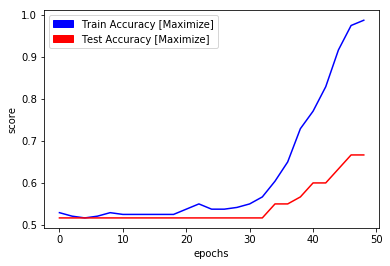

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# set up legend
blue_patch = mpatches.Patch(color='blue', label='Train Accuracy [Maximize]')
red_patch = mpatches.Patch(color='red', label='Test Accuracy [Maximize]')
plt.legend(handles=[blue_patch,red_patch])

# plot the data
x_values = range(0, N_EPOCHS, DISPLAY_EPOCH)
plt.plot(x_values, acc_train_list, color='blue')
plt.plot(x_values, acc_test_list, color='red')

plt.xlabel('epochs')
plt.ylabel('score');

###### VISUALIZE LOSS EVOLUTION

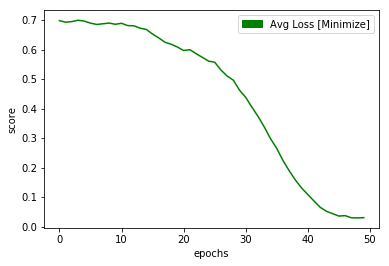

In [16]:
# set up legend
green_patch = mpatches.Patch(color='green', label='Avg Loss [Minimize]')
plt.legend(handles=[green_patch])

#plot the data
plt.plot(avg_loss_list, color='green')

plt.xlabel('epochs')
plt.ylabel('score');

##### VISUALIZE LEARNING RATE EVOLUTION

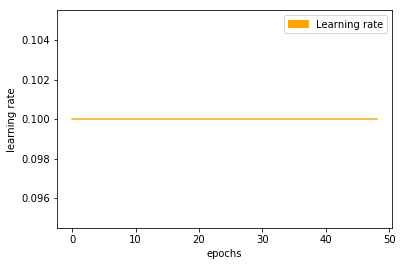

In [17]:
or_patch = mpatches.Patch(color='orange', label='Learning rate')
plt.legend(handles=[or_patch])

plt.plot(x_values, learning_list, color='orange');
plt.xlabel('epochs'.format(DISPLAY_EPOCH))
plt.ylabel('learning rate');

##### VISUALIZE TENSORBOARD

In [18]:
from IPython.display import clear_output, Image, display, HTML

#   CHECK IT ON TENSORBOARD TYPING THESE LINES IN THE COMMAND PROMPT:
#   tensorboard --logdir=/tf_logs

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = b"<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))
    
show_graph(tf.get_default_graph())

##### SHOW SAVED VARIABLES LIST
These is the list of variables that were saved on every checkpoint after training.

.data: Contains variable values

.meta: Contains graph structure

.index: Identifies checkpoints

In [19]:
for i, var in enumerate(saver._var_list):
    print('Var {}: {}'.format(i, var))

Var 0: <tf.Variable 'conv2d/kernel:0' shape=(11, 11, 3, 96) dtype=float32_ref>
Var 1: <tf.Variable 'conv2d/bias:0' shape=(96,) dtype=float32_ref>
Var 2: <tf.Variable 'conv2d_1/kernel:0' shape=(5, 5, 96, 256) dtype=float32_ref>
Var 3: <tf.Variable 'conv2d_1/bias:0' shape=(256,) dtype=float32_ref>
Var 4: <tf.Variable 'conv2d_2/kernel:0' shape=(3, 3, 256, 384) dtype=float32_ref>
Var 5: <tf.Variable 'conv2d_2/bias:0' shape=(384,) dtype=float32_ref>
Var 6: <tf.Variable 'conv2d_3/kernel:0' shape=(3, 3, 384, 384) dtype=float32_ref>
Var 7: <tf.Variable 'conv2d_3/bias:0' shape=(384,) dtype=float32_ref>
Var 8: <tf.Variable 'conv2d_4/kernel:0' shape=(3, 3, 384, 256) dtype=float32_ref>
Var 9: <tf.Variable 'conv2d_4/bias:0' shape=(256,) dtype=float32_ref>
Var 10: <tf.Variable 'cnn/W1:0' shape=(9216, 1024) dtype=float32_ref>
Var 11: <tf.Variable 'cnn/W2:0' shape=(1024, 1024) dtype=float32_ref>
Var 12: <tf.Variable 'cnn/W3:0' shape=(1024, 2) dtype=float32_ref>
Var 13: <tf.Variable 'cnn/b1:0' shape=(1